In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### compute bootstrapped CIs for the correct/incorrect difference
on hard trials only

In [13]:
# n_coord_bins = 6;
n_coord_bins = 12;
coord_bin_edges = np.linspace(2.5-0.801, 2.5+0.801, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)



n_boot_iter = 1000;
# n_boot_iter = 2;
n_boot_samp = 100;

signedconf_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
dprime_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    for ti, tt in enumerate([1,2]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        ii = ti; # focusing on the task-relevant axis here
        
        # is it a hard trial?
        is_hard = ~is_main_grid
        
        
        categ_actual = np.array(l['categ_task%d'%(ii+1)])
        
        coord_actual = pt_labs[:,ii].round(2)
        
        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        
        # was the subject correct or incorrect?
        correct = np.array(l['subject_correct'])

        inds1 = np.where(is_hard & correct)[0]
        inds2 = np.where(is_hard & ~correct)[0]
        
        
        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        print(un1, counts1)
        print(un2, counts2)
    
        print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))
        
        # loop over correct/incorrect trials
        for ci, inds in enumerate([inds1, inds2]):

            nt = len(inds)
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    if bi==0:
                        print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
                # print(len(inds_resamp))
                
                # check that the set we created has half each category
                assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
                
                # double check resample order
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                # get predictions from each ROI, these trials
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                
                    # figure out what points these 16 values correspond to
                    coords_pred = grid_pts[pred,:].round(2)
                   
                    # binarize the predictions of 16-way classifier into 2 categories
                    # based on current axis "ii"
                    categ_pred = grid_utils.get_categ(coords_pred, (ii+1))

                    prob = dec_withintask['probs_all'][si][ri][ti]

                    # "confidence" in assignment to category 2 vs 1
                    # group the 16 points into categories w/r/t relevant axis
                    g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                    p_categ1 = np.sum(prob[:,g1], axis=1)
                    g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                    p_categ2 = np.sum(prob[:,g2], axis=1)

                    # signed confidence will be: p(correct) - p(incorrect)
                    signedconf = np.zeros_like(p_categ1)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                    
                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_sepcorrect_boot[si,ri,ti,ci,bi] = d

                    signedconf_hardtrials_sepcorrect_boot[si,ri,ti,ci,bi] = np.mean(signedconf[inds_resamp])



0
[2 3 4 5 6 7 8 9] [ 8 26 30  7  7 14 11  3]
[3 4 5 6 7 8 9] [ 6 10  9  9 26 21  5]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47] [ 0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
26 17
30 17
7 17
7 17
14 17
11 17
6 17
10 17
9 17
9 17
26 17
21 17
[3 4 5 6 7 8] [ 8 14 30 26 24 14]
[3 4 5 6 7 8] [ 8 18 18 22  8  2]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33] [ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
8 17
14 17
30 17
26 17
24 17
14 17
8 17
18 17
18 17
22 17
8 17
2 17
1
[2 3 4 5 6 7 8 9] [ 6 27 11  2  7 26 37  7]
[2 3 4 5 6 7 8 9] [ 2 21 21  6  1  6 11  1]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47] [ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
6 13
27 13
11 13
2 13
7 13
26 13
37 13
7 13
2 13
21 13
21 13
6 13
1 13
6 13
11 13
1 13
[2 3 4 7 8 9] [11 23  9 21 43 11]
[2 3 4 7 8 9] [ 5 33 15  3 13  5]
[ 0.47  0.33  0.2  -0.2  -0.33 -0.47] [ 0.47  0.33  0.2  -0.2  -0.33 -0

Text(0.5, 0.98, 'Hard trials: classifier confidence, median +/- bootstrapped 95 CI')

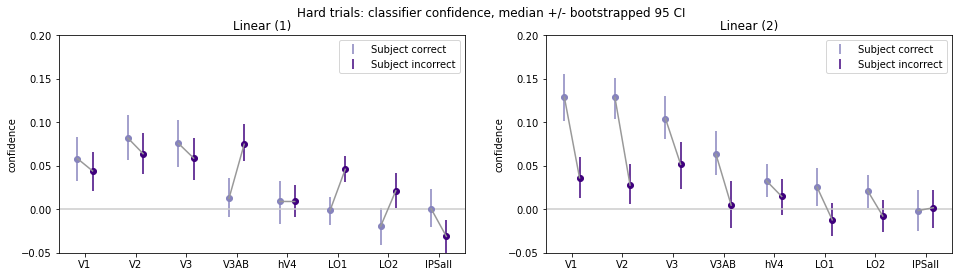

In [16]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(16,4))
    
for ti, tt in enumerate([1,2]):
   
    plt.subplot(1,2,tt)
    
    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ci, boot_vals in enumerate([signedconf_hardtrials_sepcorrect_boot[:,:,ti,0], \
                                    signedconf_hardtrials_sepcorrect_boot[:,:,ti,1]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-0.05, 0.20])

    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,['Subject correct','Subject incorrect'])
    
    plt.title(task_names[ti])
    
plt.suptitle('Hard trials: classifier confidence, median +/- bootstrapped 95 CI')


Text(0.5, 0.98, 'Hard trials: d-prime for classifying each boundary, median +/- bootstrapped 95 CI')

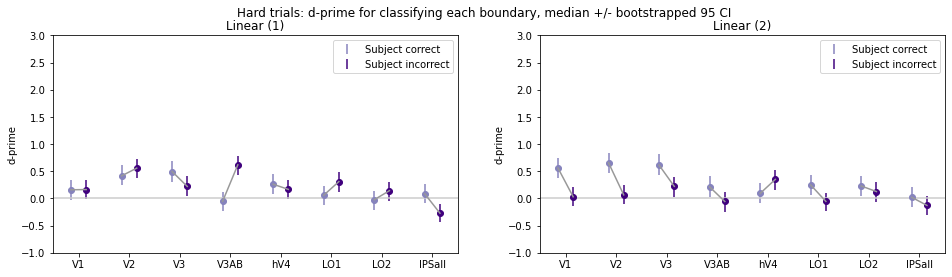

In [17]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(16,4))
    
for ti, tt in enumerate([1,2]):
   
    plt.subplot(1,2,tt)
    
    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ci, boot_vals in enumerate([dprime_hardtrials_sepcorrect_boot[:,:,ti,0], \
                                    dprime_hardtrials_sepcorrect_boot[:,:,ti,1]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-1, 3])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('d-prime')
    
    plt.legend(lh,['Subject correct','Subject incorrect'])
    
    plt.title(task_names[ti])
    
plt.suptitle('Hard trials: d-prime for classifying each boundary, median +/- bootstrapped 95 CI')


In [50]:
# n_coord_bins = 6;
n_coord_bins = 12;
coord_bin_edges = np.linspace(2.5-0.801, 2.5+0.801, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

n_boot_iter = 1000;
# n_boot_iter = 2;
n_boot_samp = 100;

signedconf_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))
dprime_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    for ti, tt in enumerate([1,2]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        ii = ti; # focusing on the task-relevant axis here
        
        # is it a hard trial?
        is_hard = ~is_main_grid
        
        
        categ_actual = np.array(l['categ_task%d'%(ii+1)])
        
        coord_actual = pt_labs[:,ii].round(2)
        
        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        
        # was the subject correct or incorrect?
        correct = np.array(l['subject_correct'])

        inds1 = np.where(is_hard & correct)[0]
        inds2 = np.where(is_hard & ~correct)[0]
        
        
        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        print(un1, counts1)
        print(un2, counts2)
    
        print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        # n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))
        
        counts1 = np.array([np.sum(coord_binned[inds1]==bb) for bb in bins_balance])

        counts2 = np.array([np.sum(coord_binned[inds2]==bb) for bb in bins_balance])

        n_samp_eachbin = np.minimum(counts1, counts2)
        
        # loop over correct/incorrect trials
        for ci, inds in enumerate([inds1, inds2]):

            nt = len(inds)
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bni, bn in enumerate(bins_balance):
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    if bi==0:
                        print(len(inds_bin), n_samp_eachbin[bni])
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin[bni], replace=False))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
                if bi==0:
                    print(len(inds_resamp))
                    print(np.mean(categ_actual[inds_resamp]==1))

                # check that the set we created has half each category
                # assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
                
                # double check resample order
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                # get predictions from each ROI, these trials
                for ri in range(n_rois):

                    pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                
                    # figure out what points these 16 values correspond to
                    coords_pred = grid_pts[pred,:].round(2)
                   
                    # binarize the predictions of 16-way classifier into 2 categories
                    # based on current axis "ii"
                    categ_pred = grid_utils.get_categ(coords_pred, (ii+1))

                    prob = dec_withintask['probs_all'][si][ri][ti]

                    # "confidence" in assignment to category 2 vs 1
                    # group the 16 points into categories w/r/t relevant axis
                    g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                    p_categ1 = np.sum(prob[:,g1], axis=1)
                    g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                    p_categ2 = np.sum(prob[:,g2], axis=1)

                    # signed confidence will be: p(correct) - p(incorrect)
                    signedconf = np.zeros_like(p_categ1)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                    
                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_sepcorrect_boot[si,ri,ti,ci,bi] = d

                    signedconf_hardtrials_sepcorrect_boot[si,ri,ti,ci,bi] = np.mean(signedconf[inds_resamp])

0
[2 3 4 5 6 7 8 9] [ 8 26 30  7  7 14 11  3]
[3 4 5 6 7 8 9] [ 6 10  9  9 26 21  5]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47] [ 0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
26 6
30 10
7 7
7 7
14 14
11 11
55
0.41818181818181815
6 6
10 10
9 7
9 7
26 14
21 11
55
0.41818181818181815
[3 4 5 6 7 8] [ 8 14 30 26 24 14]
[3 4 5 6 7 8] [ 8 18 18 22  8  2]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33] [ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
8 8
14 14
30 18
26 22
24 8
14 2
72
0.5555555555555556
8 8
18 14
18 18
22 22
8 8
2 2
72
0.5555555555555556
1
[2 3 4 5 6 7 8 9] [ 6 27 11  2  7 26 37  7]
[2 3 4 5 6 7 8 9] [ 2 21 21  6  1  6 11  1]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47] [ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
6 2
27 21
11 11
2 2
7 1
26 6
37 11
7 1
55
0.6545454545454545
2 2
21 21
21 11
6 2
1 1
6 6
11 11
1 1
55
0.6545454545454545
[2 3 4 7 8 9] [11 23  9 21 

Text(0.5, 0.98, 'Hard trials: classifier confidence, median +/- bootstrapped 95 CI')

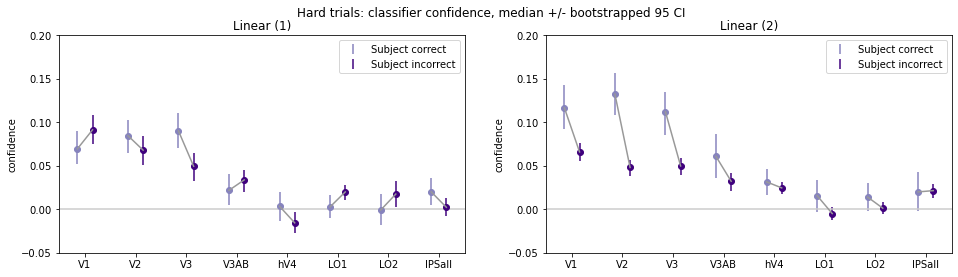

In [51]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(16,4))
    
for ti, tt in enumerate([1,2]):
   
    plt.subplot(1,2,tt)
    
    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ci, boot_vals in enumerate([signedconf_hardtrials_sepcorrect_boot[:,:,ti,0], \
                                    signedconf_hardtrials_sepcorrect_boot[:,:,ti,1]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-0.05, 0.20])

    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,['Subject correct','Subject incorrect'])
    
    plt.title(task_names[ti])
    
plt.suptitle('Hard trials: classifier confidence, median +/- bootstrapped 95 CI')


In [37]:
si = 0; ss = 1;
ti = 0; tt = 1;
ii = 0;

l = lab[ss][lab[ss]['task']==tt]

pt_labs = np.array([l['ptx'], l['pty']]).T

is_main_grid = l['is_main_grid']==1

ii = ti; # focusing on the task-relevant axis here

# is it a hard trial?
is_hard = ~is_main_grid


categ_actual = np.array(l['categ_task%d'%(ii+1)])

coord_actual = pt_labs[:,ii].round(2)

# make rough bins that help equate stimulus distributions
# across tasks when bootstrapping
coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
for cb in np.arange(n_coord_bins):
    binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
    coord_binned[binds] = cb
assert(np.all(coord_binned[is_hard]>-1))


# was the subject correct or incorrect?
correct = np.array(l['subject_correct'])

inds1 = np.where(is_hard & correct)[0]
inds2 = np.where(is_hard & ~correct)[0]


# now figure out which bins we can use and still have everything balanced in both correct/incorrect
un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

print(un1, counts1)
print(un2, counts2)

print(bin_dist[un1], bin_dist[un2])

bins_balance = []
for uu in np.union1d(un1, un2):
    d = bin_dist[uu]
    in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
    in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
    if in1 and in2:
        bins_balance += [uu]

print(bin_dist[bins_balance])

# checking that the bins we are using represent each category equally
assert(np.mean(bin_dist[bins_balance]<0)==0.5)

n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))


[2 3 4 5 6 7 8 9] [ 8 26 30  7  7 14 11  3]
[3 4 5 6 7 8 9] [ 6 10  9  9 26 21  5]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47] [ 0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33]


In [45]:
counts1 = np.array([np.sum(coord_binned[inds1]==bb) for bb in bins_balance])

counts2 = np.array([np.sum(coord_binned[inds2]==bb) for bb in bins_balance])

n_samp_eachbin = np.minimum(counts1, counts2)

In [33]:
for bb in bins_balance:
    
    inds1 = np.where(is_hard & correct & (coord_binned==bb))[0]
    inds2 = np.where(is_hard & ~correct & (coord_binned==bb))[0]

    print(len(inds1), len(inds2))
    
    minsamp = np.minimum(len(inds1), len(inds2))
    
    # inds_use = []
    for idx in [inds1, inds2]:
        
        if len(idx)==minsamp:
            
            inds_use += [idx]
            
        else:
            
            inds_use += [np.random.choice(idx, minsamp, replace=False)]
    
    inds_use = np.concatenate(inds_use,axis=0)
    print(coord_binned[inds_use])

26 6
[3 3 3 3 3 3 3 3 3 3 3 3]
30 10
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
7 9
[5 5 5 5 5 5 5 5 5 5 5 5 5 5]
7 9
[6 6 6 6 6 6 6 6 6 6 6 6 6 6]
14 26
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
11 21
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


In [32]:

inds_use

array([203, 189,  76, 177,  69, 225,  64,  94, 146, 159, 198, 239])

#### compute bootstrapped CIs for the correct/incorrect difference
on Checker Task hard trials only

In [36]:

n_coord_bins = 12;
coord_bin_edges = np.linspace(-0.801, 0.801, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
# bin_dist = (center-bin_centers).round(2)
bin_dist = bin_centers.round(2)

n_boot_iter = 1000;
# n_boot_iter = 2;
n_boot_samp = 100;

signedconf_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 1, 2, n_boot_iter))
dprime_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 1, 2, n_boot_iter))

# checker task only
ti = 2; tt = 3;


for si, ss in enumerate(subjects):

    print(si)

    l = lab[ss][lab[ss]['task']==3]

    pt_labs = np.array([l['ptx'], l['pty']]).T

    is_main_grid = l['is_main_grid']==1

    # is it a hard trial?
    is_hard = ~is_main_grid


    categ_actual = np.array(l['categ_task3'])

    coord_actual = np.array(l['dist_from_bound3'])
    coord_actual[categ_actual==1] = (-1)*coord_actual[categ_actual==1]

    # make rough bins that help equate stimulus distributions
    # across tasks when bootstrapping
    coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
    for cb in np.arange(n_coord_bins):
        binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
        coord_binned[binds] = cb
    assert(np.all(coord_binned[is_hard]>-1))


    # was the subject correct or incorrect?
    correct = np.array(l['subject_correct'])

    inds1 = np.where(is_hard & correct)[0]
    inds2 = np.where(is_hard & ~correct)[0]


    # now figure out which bins we can use and still have everything balanced in both correct/incorrect
    un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
    un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

    print(un1, counts1)
    print(un2, counts2)

    print(bin_dist[un1], bin_dist[un2])

    bins_balance = []
    for uu in np.union1d(un1, un2):
        d = bin_dist[uu]
        in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
        in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
        if in1 and in2:
            bins_balance += [uu]

    print(bin_dist[bins_balance])

    # checking that the bins we are using represent each category equally
    assert(np.mean(bin_dist[bins_balance]<0)==0.5)

    n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

    # loop over correct/incorrect trials
    for ci, inds in enumerate([inds1, inds2]):

        nt = len(inds)

        for bi in range(n_boot_iter):

            # make a resampling order that represents each bin equally
            inds_resamp = []
            for bn in bins_balance:
                inds_bin = inds[coord_binned[inds]==bn]
                assert(len(inds_bin)>0)
                if bi==0:
                    print(len(inds_bin), n_samp_eachbin)
                inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
            inds_resamp = np.concatenate(inds_resamp, axis=0)
            # print(len(inds_resamp))

            # check that the set we created has half each category
            assert(np.mean(categ_actual[inds_resamp]==1)==0.5)

            # double check resample order
            assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
            counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
            assert(np.all(counts==n_samp_eachbin))

            # get predictions from each ROI, these trials
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti].astype(int)

                # figure out what points these 16 values correspond to
                coords_pred = grid_pts[pred,:].round(2)

                # binarize the predictions of 16-way classifier into 2 categories
                # based on current axis "ii"
                categ_pred = grid_utils.get_categ(coords_pred, 3)

                prob = dec_withintask['probs_all'][si][ri][ti]

                # "confidence" in assignment to category 2 vs 1
                # group the 16 points into categories w/r/t relevant axis
                g1 = grid_utils.get_categ(grid_pts, 3)==1
                p_categ1 = np.sum(prob[:,g1], axis=1)
                g2 = grid_utils.get_categ(grid_pts, 3)==2
                p_categ2 = np.sum(prob[:,g2], axis=1)

                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

                d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                dprime_hardtrials_sepcorrect_boot[si,ri,0,ci,bi] = d

                signedconf_hardtrials_sepcorrect_boot[si,ri,0,ci,bi] = np.mean(signedconf[inds_resamp])



0
[2 3 8 9] [38 20 31 42]
[2 3 8 9] [18 20  9 14]
[-0.47 -0.33  0.33  0.47] [-0.47 -0.33  0.33  0.47]
[-0.47 -0.33  0.33  0.47]
38 25
20 25
31 25
42 25
18 25
20 25
9 25
14 25
1
[2 3 4 7 8 9] [12 39  9  8 46 10]
[2 3 4 7 8 9] [ 4 25  7  8 18  6]
[-0.47 -0.33 -0.2   0.2   0.33  0.47] [-0.47 -0.33 -0.2   0.2   0.33  0.47]
[-0.47 -0.33 -0.2   0.2   0.33  0.47]
12 17
39 17
9 17
8 17
46 17
10 17
4 17
25 17
7 17
8 17
18 17
6 17
2
[ 1  2  3  8  9 10] [10 34  8 12 56 14]
[ 1  2  3  8  9 10] [ 6 30  8  4  8  2]
[-0.6  -0.47 -0.33  0.33  0.47  0.6 ] [-0.6  -0.47 -0.33  0.33  0.47  0.6 ]
[-0.6  -0.47 -0.33  0.33  0.47  0.6 ]
10 17
34 17
8 17
12 17
56 17
14 17
6 17
30 17
8 17
4 17
8 17
2 17
3
[2 3 4 7 8 9] [37 18  4  3 28 41]
[2 3 4 7 8 9] [19 14  4  5  4 15]
[-0.47 -0.33 -0.2   0.2   0.33  0.47] [-0.47 -0.33 -0.2   0.2   0.33  0.47]
[-0.47 -0.33 -0.2   0.2   0.33  0.47]
37 17
18 17
4 17
3 17
28 17
41 17
19 17
14 17
4 17
5 17
4 17
15 17
4
[3 8] [46 83]
[3 8] [50 13]
[-0.33  0.33] [-0.33  0.33]
[-0.

Text(0.5, 0.98, 'Hard trials in Checker Task: classifier confidence, median +/- bootstrapped 95 CI')

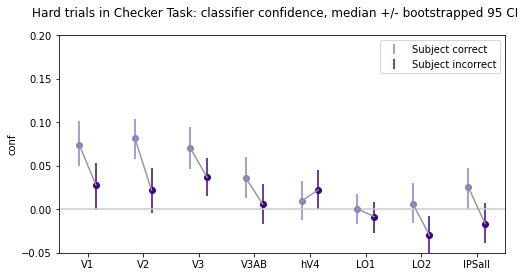

In [37]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(8,4))
   
colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

plt.axhline(0, color=[0.8, 0.8, 0.8])

lh = []

mtmp = []
for ci, boot_vals in enumerate([signedconf_hardtrials_sepcorrect_boot[:,:,0,0,:], \
                                signedconf_hardtrials_sepcorrect_boot[:,:,0,1,:]]):

    x_ticks = np.arange(n_rois) + x_jitter[ci]

    # average over subjects (within each bootstrapping iteration)
    boot_vals_avg = np.mean(boot_vals, axis=0)
    boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)

    # get percentiles of the bootstrapped distrib
    median_vals = boot_pct[1]
    mtmp.append(median_vals)
    lower_vals = median_vals - boot_pct[0]
    upper_vals = boot_pct[2] - median_vals

    plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
    h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
    lh.append(h)

for ri in range(n_rois):

    median_vals = [mtmp[0][ri], mtmp[1][ri]]
    plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

plt.ylim([-0.05, 0.20])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('conf')

plt.legend(lh,['Subject correct','Subject incorrect'])

plt.suptitle('Hard trials in Checker Task: classifier confidence, median +/- bootstrapped 95 CI')


Text(0.5, 0.98, 'Hard trials in Checker Task: d-prime for discriminating checker categories, median +/- bootstrapped 95 CI')

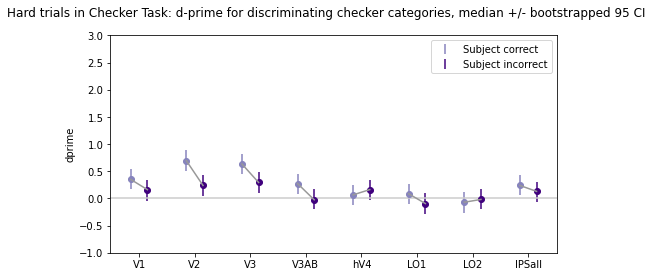

In [39]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(8,4))
   
colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

plt.axhline(0, color=[0.8, 0.8, 0.8])

lh = []

mtmp = []
for ci, boot_vals in enumerate([dprime_hardtrials_sepcorrect_boot[:,:,0,0,:], \
                                dprime_hardtrials_sepcorrect_boot[:,:,0,1,:]]):

    x_ticks = np.arange(n_rois) + x_jitter[ci]

    # average over subjects (within each bootstrapping iteration)
    boot_vals_avg = np.mean(boot_vals, axis=0)
    boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)

    # get percentiles of the bootstrapped distrib
    median_vals = boot_pct[1]
    mtmp.append(median_vals)
    lower_vals = median_vals - boot_pct[0]
    upper_vals = boot_pct[2] - median_vals

    plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
    h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
    lh.append(h)

for ri in range(n_rois):

    median_vals = [mtmp[0][ri], mtmp[1][ri]]
    plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

plt.ylim([-1, 3])

plt.xticks(np.arange(n_rois), roi_names)
plt.ylabel('dprime')

plt.legend(lh,['Subject correct','Subject incorrect'])

plt.suptitle('Hard trials in Checker Task: d-prime for discriminating checker categories, median +/- bootstrapped 95 CI')
